<div style="text-align: center;padding-top:10px;padding-bottom:10px">
    <a href="https://geostatisticslessons.com/" target="_blank" style="color:#93c6c7" >
    <img src="https://geostatisticslessons.com/favicon-96x96.png" alt="Geostatistics Lessons Link" style="width:100px">
    </a>
</div>

<div style="text-align: center">
    <font style="color:#00797C;padding-bottom:-100px"><center><b><font size="+3">Cokriging with Unequally Sampled Data</font></b></center></p>
    <font style="color:#00797C;padding-bottom:50px"><center><b><font size="+2">A Companion Notebook to Geostatistics Lessons</font></b></center></p>    
</div>

<p class="author" style="padding: 0;"><center><b>Luis Davila and Ryan Barnett</b></center></p>
<p class="date" style="padding: 0;"><center><b>March 28, 2025</b></center></p>

---

# Outline

The following notebook accompanies the lesson [Cokriging with Unequally Sampled Data](https://geostatisticslessons.com/lessons/cokrigingunequal). A dataset containing blasthole and drillhole data is used to apply cokriging and then compare to kriging results.

1. **Load data**
    - Load exploration (Expl) and blast hole (BH) copper data (heterotopic data)
    - Inspect the paired data bias and generate a model grid, where it is shown that the BH data is globally biased
1. **Calculate Experimental Variogram and Cross-Variogram**
    - Calculate cross-covariance for inferring zero-lag covariance, and get the cross variogram
    - Calculate direct variograms for BH and Expl data
1. **LMC Fitting**
   - Fit simultaneously the direct and cross variograms to a Linear Model of Corregionalization (LMC)
1. **Cokriging**
    - Estimate using ordinary cokriging (OCK). Note that variable standardization is internally done by `rmsp.CoKrigeEstimator`
1. **Comparison to Alternatives**
   - Perform OCK, but with an intrinsic model of coregionalization, which is more simple to parameterize than an LMC
   - Perform ordinary kriging (OK) with Expl data, avoiding use of the biased BH data
   - Perform OK with Expl and BH data as if they have the same support
   - Compare the four estimated models in terms of cross-validation and visual characteristics
   
The presented workflow may be extended to represent other deposits. Inline annotations with each step will note practical adjustments that may be necessary for this extension.

---

Import required packages:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import rmsp

rmsp.activate()

License cleq45ynq00hqgomxnox1w5wo checked out by ryan@resmodsol.com to clhpc9e08024vlb2mj25gvz0b expires in 45 minutes. RMSP is up to date!


Standard plotting parameters that will be used throughout the notebook:

In [2]:
cu = rmsp.Variable("Cu").set_variable_params(
    clim=(0.0, 1.0), cmap_log=False, cmap="Spectral_r"
)
rmsp.GlobalParams["plotting.grid"] = True
rmsp.GlobalParams['plotting.sigdigs'] = 3

---
# Load Data

Load composites, and inspect the head/tail rows:

In [3]:
comps = rmsp.load_example_data("expl_bh")
comps

,Easting,Northing,Elevation,Expl Cu,BH Cu,Ore Control Area
0,26.583068,27.712766,0.5,0.221,NaN,0
1,77.279413,25.350438,0.5,0.380,NaN,0
2,126.887066,27.535255,0.5,0.328,NaN,0
3,176.391096,27.801878,0.5,1.566,NaN,0
4,226.998975,25.614170,0.5,0.610,NaN,0
...,...,...,...,...,...,...
1509,755.230000,504.720000,0.5,NaN,0.042233,1
1510,743.860000,507.250000,0.5,NaN,0.010566,1
1511,733.590000,511.970000,0.5,NaN,-0.010000,1
1512,706.980000,513.800000,0.5,NaN,0.023710,1


Note the `'Expl Cu'` and `'BH Cu'` columns above, where  measured `'Expl Cu'` indicates an exploration (diamond drill hole) composite, and NaN `'Expl Cu'` values indicate a blasthole composite, and vice versa.

Setup `expl` and `bh` to inherit (clone) the defined Cu plotting parameters (colormap, color limits, etc), so they're automatically applied to the noted columns above. Also setup dictionaries to standardize plotting of each dataset in section views.

In [4]:
expl = cu.clone("Expl Cu")
bh = cu.clone("BH Cu")
expl_pars = dict(label="Expl", marker="s", s=20, ec="k")
bh_pars = dict(label="BH", s=5)
lim_pars = dict(xlim=(0, 1000), ylim=(0, 600))

Plot data location and histograms:

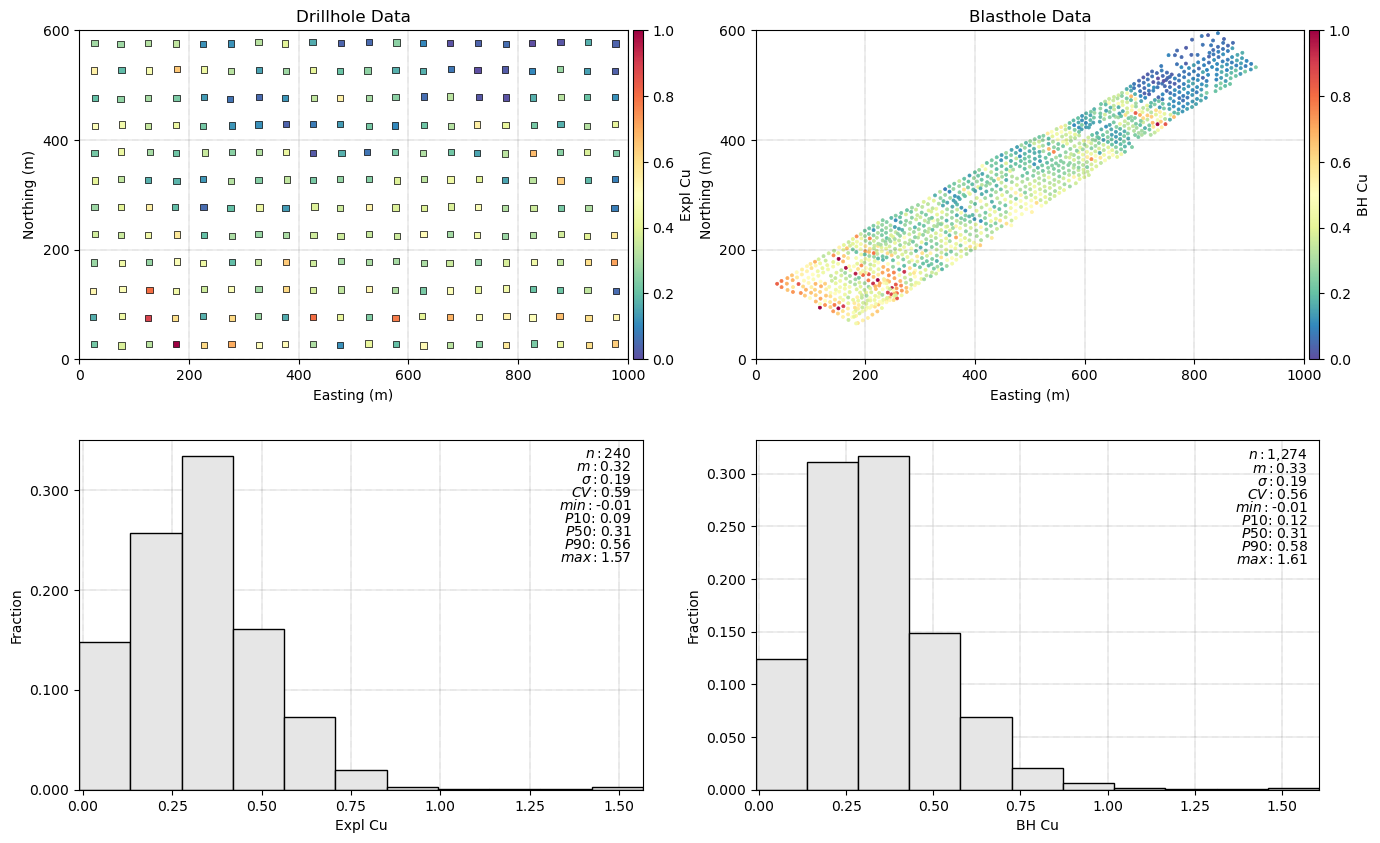

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()
comps.sectionplot(
    expl.col,
    **expl_pars,
    **lim_pars,
    ax=axes[0],
    title="Drillhole Data",
)
comps.sectionplot(
    bh.col,
    **bh_pars,
    **lim_pars,
    ax=axes[1],
    title="Blasthole Data",
)
comps.histplot(expl.col, ax=axes[2], bin_type="fraction")
comps.histplot(bh.col, ax=axes[3], bin_type="fraction")

Inspect bias and relation by pairing blast/exploration holes within 8m. Note that the blast holes are locally accurate from the scatterplot (considering expected short scale variability plus nugget effect), but exhibit a positive global bias in grades according to the CDF/Q-Q plots, which is summarized by the 10% mean increase. This indicates that the blast holes should be modeled with cokriging, so their local information may be incorporated without introducing a global bias.

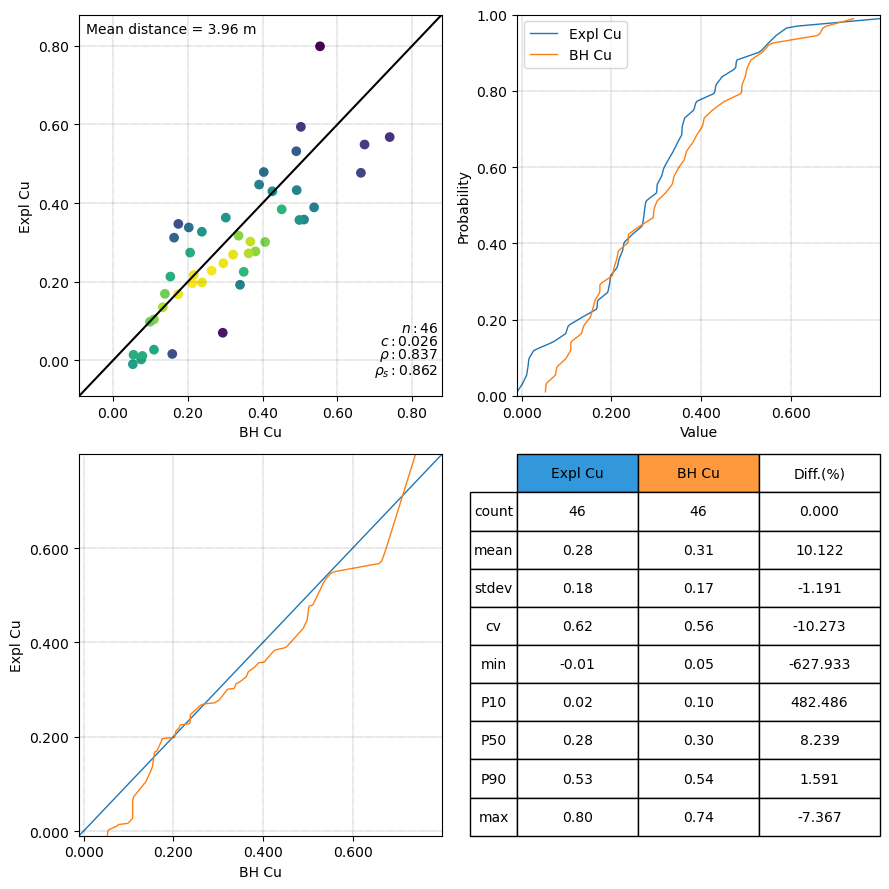

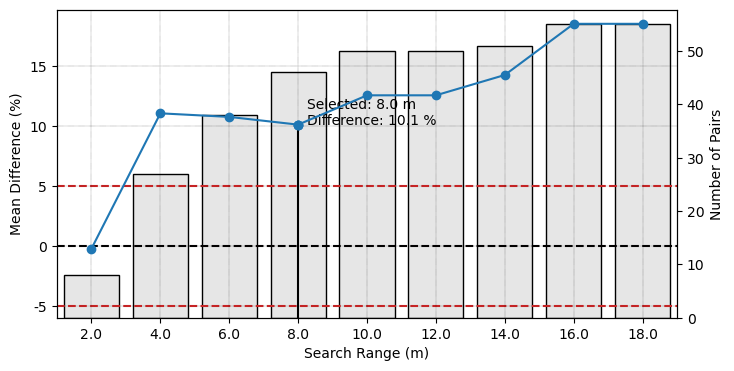

In [6]:
is_expl = comps[expl.col].isna()
pairs = rmsp.Pair(
    comps.loc[~is_expl],
    expl.col,
    comps.loc[is_expl],
    bh.col,
    rmsp.Search(ranges=[8] * 3, min_comps=1, max_comps=1),
    prefixes=[""] * 2,
    test_ranges=np.arange(2, 20, 2),
)
pairs.summarize()
_ = pairs.test_plot(figsize=(8, 4), tol=5)

Initialize a grid for estimating in subsequent sections, considering blocks within 50m:

In [7]:
grid = rmsp.GridData.from_scattered_points(
    comps, 10.0, 10.0, 10.0, srch_radius=50.0
)
grid.griddef.to_table()

,Easting,Northing
minimum (m),20.26,20.09
maximum (m),990.26,600.09
size (m),10.0,10.0
number,97,58


---
# Calculate Experimental Variogram and Cross-Variogram

Function for plotting experimental variograms, which we will re-use in this and subsequent sections. Omni-directional variograms are calculated and modeled in this notebook for streamlining the demonstration, although directional variograms would be used in practice.

In [8]:
def plot_omni_vario(vario, title="", sill=1.0, ylim=(0, 1.3)):
    fig, ax = vario.plot(figsize=(7, 5), ylim=ylim, sill=sill, title=title)
    return ax

Calculate cross-covariance for inferring zero-lag covariance. The `cov` variable and displayed sill marks the chosen covariance. Note that cross-covariance must be calculated (before converting to a cross-variogram in subsequent cells), as there are no colocated pairs available (required for cross-variograms but not cross-covariance).

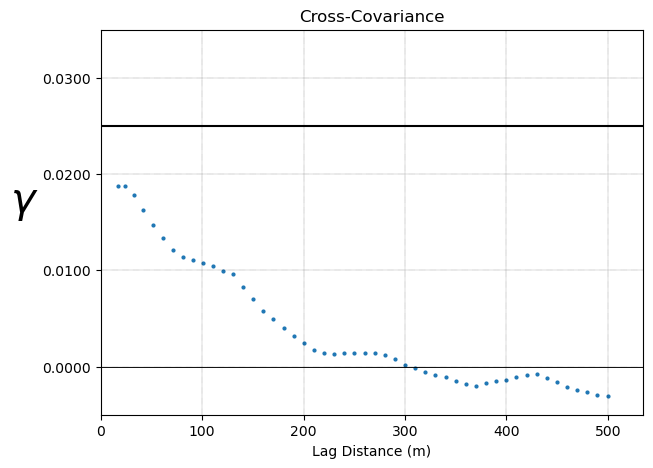

In [9]:
searches = [
    rmsp.ExpVarioSearch(0.0, 0.0, rmsp.Lags(10.0, 15, 50), azmtol=90)
]
crosscov = rmsp.CrossExpVario("covariance", standardize=False).calculate(
    comps, expl.col, bh.col, searches
)
cov = 0.025
_ = plot_omni_vario(crosscov, "Cross-Covariance", cov, (-0.005, 0.035))

Given the chosen zero-lag covariance, calculate the standardized sill (correlation), as well as the sills of the variograms and cross-variograms for future standardization:

In [10]:
corr = cov / (comps[expl.col].std(ddof=0) * comps[bh.col].std(ddof=0))
sills = {
    expl.col: comps[expl.col].var(ddof=0),
    bh.col: comps[bh.col].var(ddof=0),
}
sills[(expl.col, bh.col)] = cov

Now calculate the standardized and flipped cross-covariance, which is treated as the standardized cross-variogram under a second order assumption of stationarity and the relation $\gamma(h) = C(0) - C(h)$

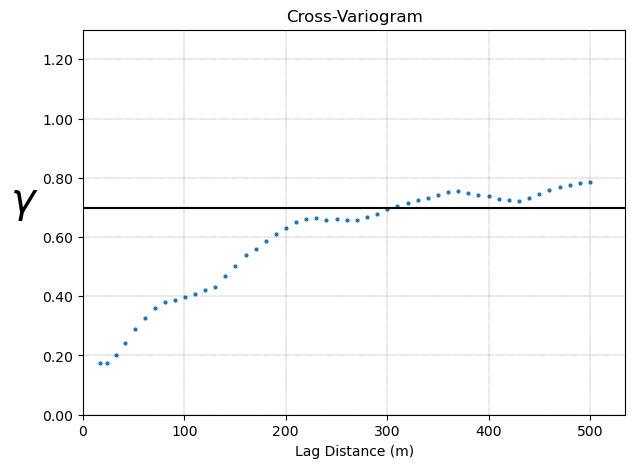

In [11]:
crossvario = rmsp.CrossExpVario(
    "covariance_f",
    standardize=True,
    sill=sills[(expl.col, bh.col)],
    head_variance=sills[expl.col],
    tail_variance=sills[bh.col],
).calculate(comps, expl.col, bh.col, searches)
_ = plot_omni_vario(crossvario, "Cross-Variogram", corr)

Calculate the exploration variogram using its appropriate lag tolerances (far wider than blast hole tolerances that follow). Searches in different directions can be implemented if working with directional variography.

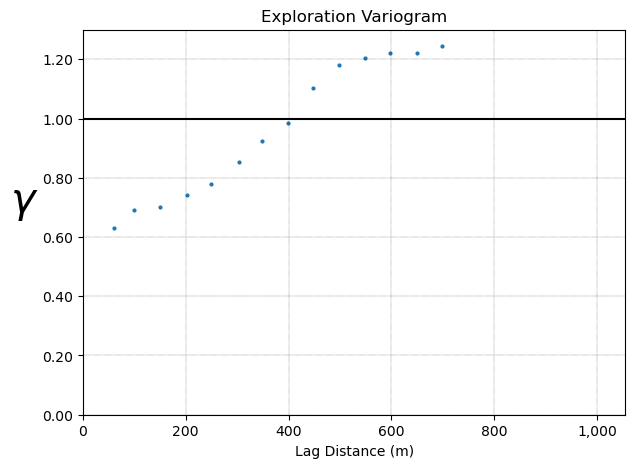

In [12]:
searches = [
    rmsp.ExpVarioSearch(0.0, 0.0, rmsp.Lags(50.0, 40, 20), azmtol=90)
]
explvario = rmsp.ExpVario().calculate(comps, expl.col, searches)
_ = plot_omni_vario(explvario, "Exploration Variogram")

Calculate the blast hole variogram using its appropriate lag tolerances (far tighter than the exploration tolerances above):

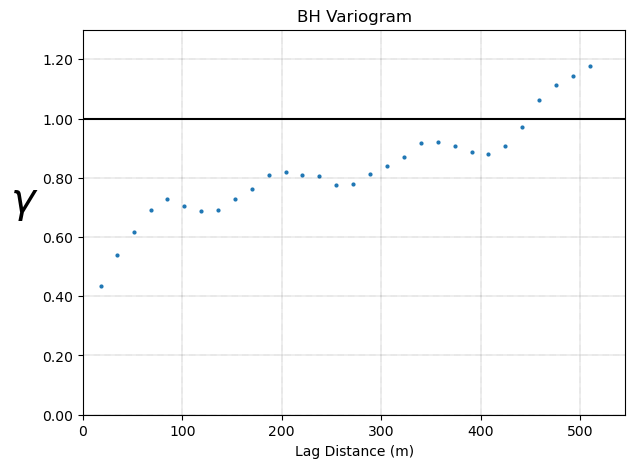

In [13]:
searches = [
    rmsp.ExpVarioSearch(0.0, 0.0, rmsp.Lags(17.0, 8.5, 30), azmtol=90.0)
]
bhvario = rmsp.ExpVario().calculate(comps, bh.col, searches)
_ = plot_omni_vario(bhvario, "BH Variogram")

---
# LMC Fitting

Initialize full direct and cross experimental variograms:

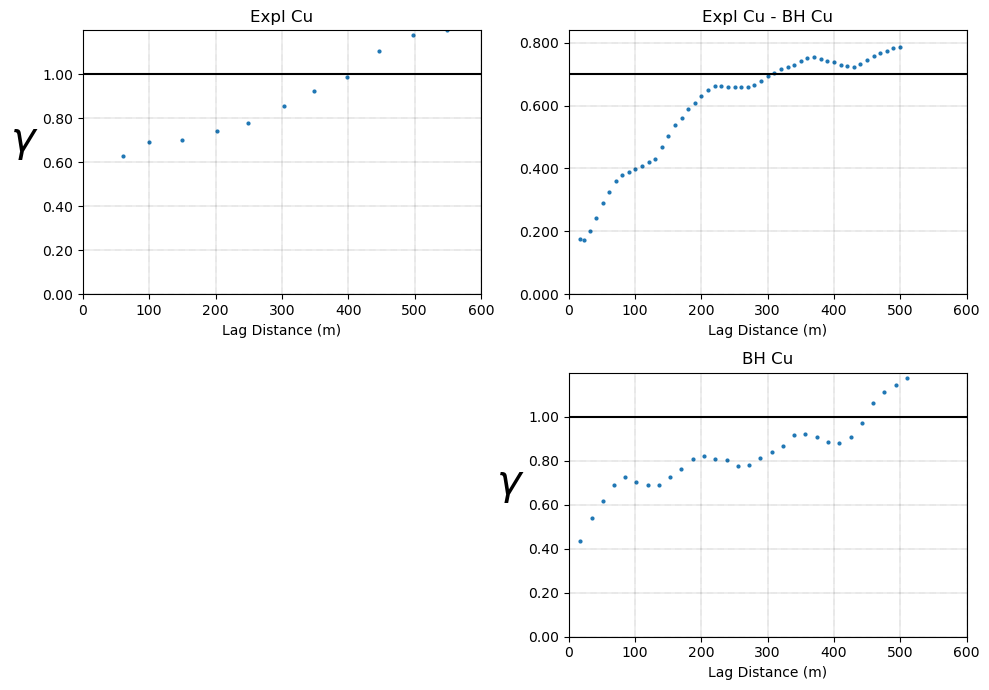

In [14]:
varios = {
    expl.col: explvario,
    (expl.col, bh.col): crossvario,
    bh.col: bhvario,
}
variables = [expl.col, bh.col]
expvarios = rmsp.FullExpVarios(variables, varios=varios)
fig, axes = expvarios.plot(azm=0.0, figsize=(10, 7), xlim=(0, 600))

Specify an LMC - the variance contributions for each structure are square, symmetric matrices with direct contributions on the diagonal and cross contributions on the off-diagonal. 

In [15]:
covario_dict = dict(
    num_struct=2,
    shapes=["spherical"] * 2,
    nugget=[[0.25, 0.0], [0.0, 0.20]],
    var_contribs=[
        [[0.3, 0.27], [0.27, 0.3]],
        [[0.45, 0.43], [0.43, 0.50]],
    ],
    angles=[[0.0] * 3] * 2,
    ranges=[
        [70.0] * 3,
        [450.0] * 3,
    ],
)
covario = rmsp.CoVarioModel([expl.col, bh.col], covario_dict)
covario.to_table()

,Nugget,Structure 1,Structure 2
Expl Cu--Expl Cu,0.250,0.300,0.450
Expl Cu--BH Cu,0.000,0.270,0.430
BH Cu--BH Cu,0.200,0.300,0.500
Model Shape,,spherical,spherical
Angle 1,,0.0,0.0
Angle 2,,0.0,0.0
Angle 3,,0.0,0.0
Range 1,,70.0,450.0
Range 2,,70.0,450.0
Range 3,,70.0,450.0


Plot with the experimental variograms:

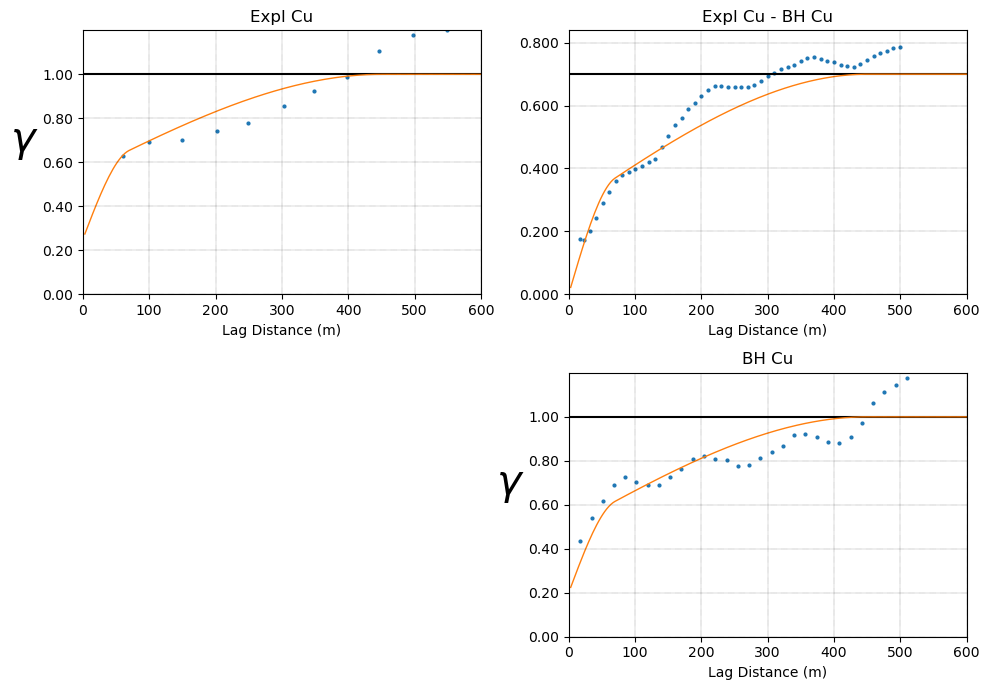

In [16]:
fig, axes = expvarios.plot(
    figsize=(10, 7),
    xlim=(0, 600),
)
covario.plot_draw(axes)

---
# Cokriging

Setup searches for the exploration and blastholes:

In [17]:
searches = [
    rmsp.Search([0.0, 0.0, 0.0], [400.0, 300, 1.0], 4, 24),
    rmsp.Search([0.0, 0.0, 0.0], [80.0, 60, 1.0], 2, 24),
]

Calculate means and standard deviations; used for standardization of the primary/secondary and for the SCK/OCK mean:

In [18]:
means = [comps[var].mean() for var in variables]
stdevs = [comps[var].std(ddof=0) for var in variables]

Initialize the cokriging estimator:

In [19]:
cokrige = rmsp.CoKrigeEstimator(
    ktype="ock",
    searches=searches,
    vario=covario,
    means=means,
    stdevs=stdevs,
    copy_meta=False,
)

Estimate across the grid:

In [20]:
grid["Cu OCK Estimate"], grid["Cu OCK Estimation Variance"] = (
    cokrige.estimate(
        grid,
        comps,
        [expl.col, bh.col],
        output=["estimate", "estimate_var"],
        copy_meta=False,
    )
)

Define a function to plot estimates, which we will re-use for visualizing alternative estimation methods:

In [21]:
def plot_estimate(primary, secondary, estimate, variance, include_bh=True):
    fig, axes = plt.subplots(3, 1, figsize=(8, 13), sharex=True)
    comps.sectionplot(
        primary, ax=axes[0], **expl_pars, **lim_pars, cbar_label="Cu"
    )
    if include_bh:
        comps.sectionplot_draw(axes[0], secondary, **bh_pars, zorder=-1)
    axes[0].legend(loc=2)
    grid.sectionplot(estimate, ax=axes[1])
    grid.sectionplot(
        variance, cbar_label="Cu^2", ax=axes[2], clim=(0.4, 0.6)
    )
    fig.tight_layout()
    return fig, axes

Plot:

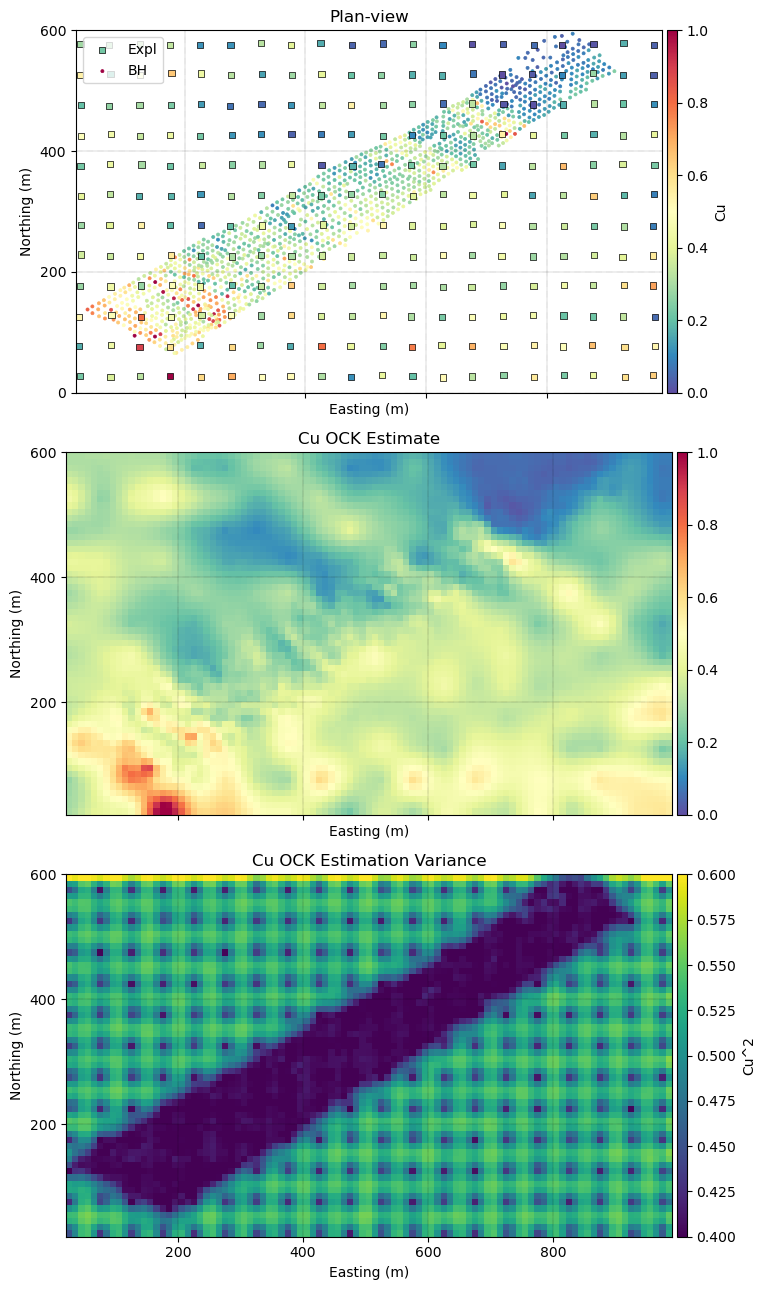

In [22]:
cu.clone("Cu OCK Estimate")  # copy color parameters
fig1, axes1 = plot_estimate(
    expl.col, bh.col, "Cu OCK Estimate", "Cu OCK Estimation Variance"
)

---
# Comparison to Alternatives

Compare the OCK-LMC result above with:
- OCK using a simplified model of coregionalization that is more practical to apply
- Ordinary kriging (OK) using only exploration data
- OK using exploration and blasthole data (e.g., disregarding blasthole data issues and treating as exploration)

## Cokriging with the intrinsic model of coregionalization
Identical to the OCK above, only varying in the use of an intrinsic model instead of the LMC. The intrinsic model assumes the cross covariance is the same shape as the direct variogram, but scaled by the zero-lag correlation. This assumption greatly simplifies LMC inferrence, but may lead to suboptimal cross variogram fits.

Extract the `'Expl Cu'` component of the LMC. If using the intrinsic model in practice, `vario` would likely be generated through `VarioModel.fit_experimental`.

In [23]:
vario = covario.get_variomodel(expl.col)

Generate a `CoVarioModel` from an intrinsic model of coregionalization:

In [24]:
intrinsic = rmsp.CoVarioModel.from_intrinsic(
    variables, vario, [[1.0, corr], [corr, 1.0]]
)

Plot with the experimental variogram. Note that the instrinsic model fit is not quite as good as the LMC, particularly for the cross variogram:

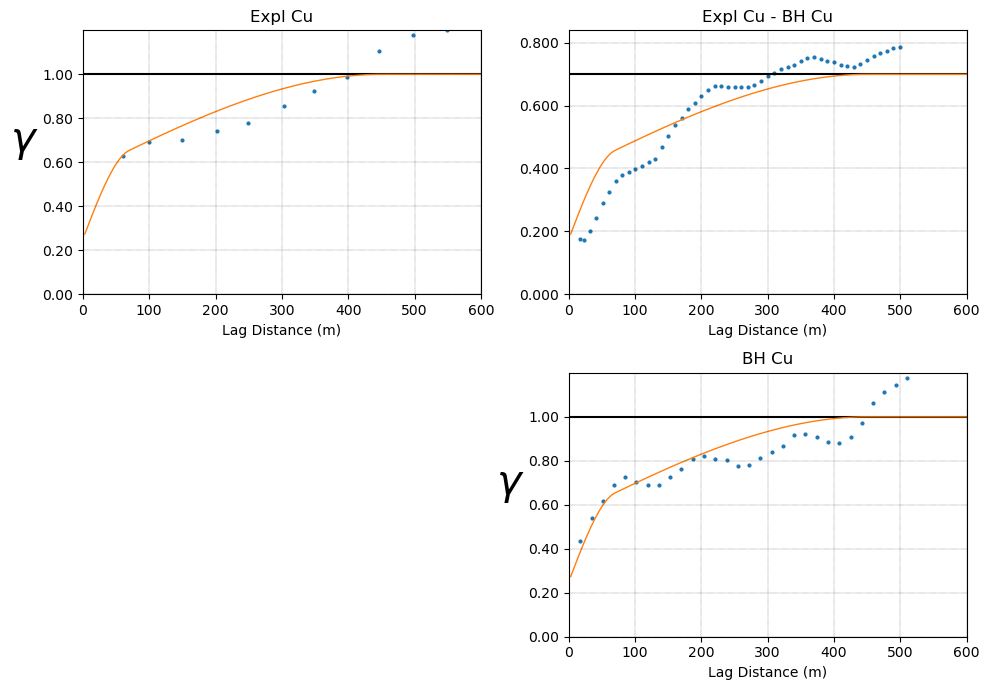

In [25]:
fig, axes = expvarios.plot(
    figsize=(10, 7),
    xlim=(0, 600),
)
intrinsic.plot_draw(axes)

Initialize the cokriging estimator using the intrinsic model:

In [26]:
intrinsic = rmsp.CoKrigeEstimator(
    ktype="ock",
    searches=searches,
    vario=intrinsic,
    means=means,
    stdevs=stdevs,
)

Estimate across the grid:

In [27]:
cu.clone("Cu OCK intrinsic Estimate")

(
    grid["Cu OCK intrinsic Estimate"],
    grid["Cu OCK intrinsic Estimation Variance"],
) = intrinsic.estimate(
    grid,
    comps,
    [expl.col, bh.col],
    output=["estimate", "estimate_var"],
    copy_meta=False,
)

Plot the estimates:

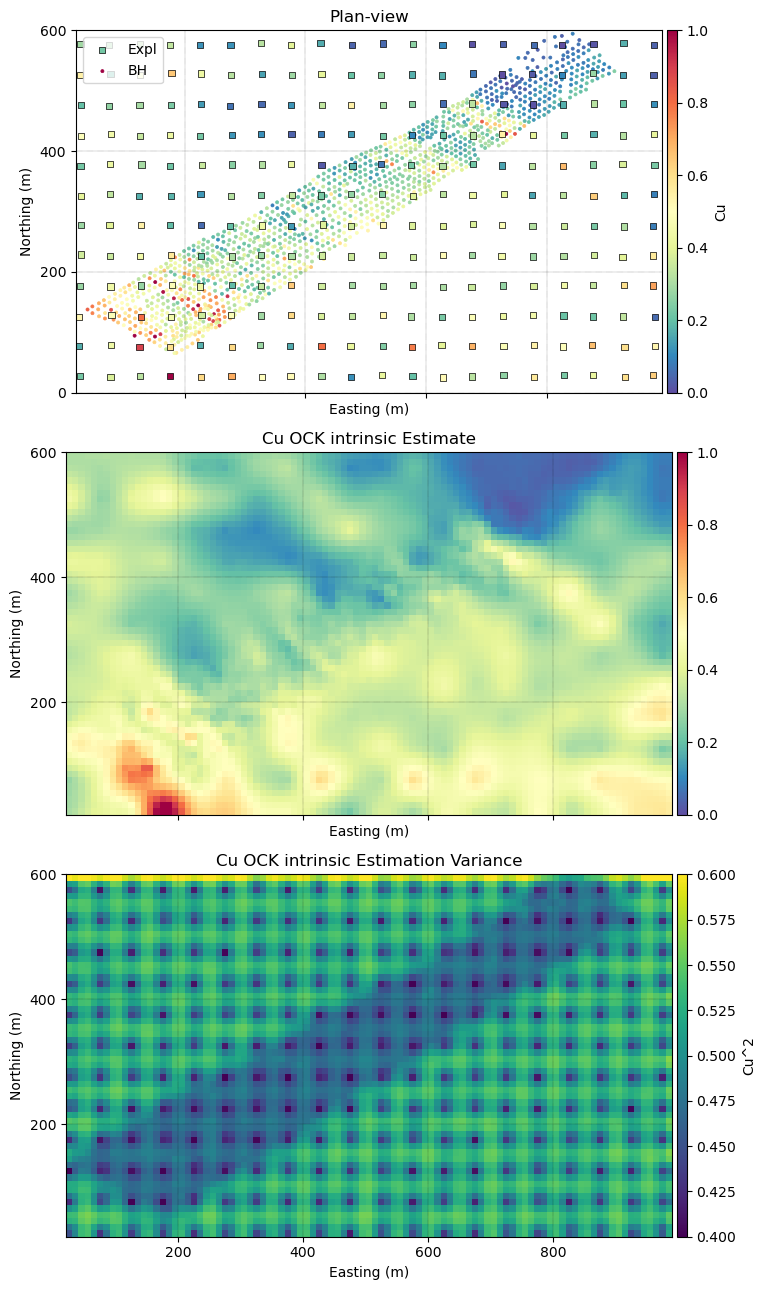

In [28]:
fig, axes = plot_estimate(
    expl.col,
    bh.col,
    "Cu OCK intrinsic Estimate",
    "Cu OCK intrinsic Estimation Variance",
)

## Ordinary kriging with exploration data

Initialize the OK estimator, using the variogram and search defined in the prior section:

In [29]:
krige = rmsp.KrigeEstimator(search=searches[0], vario=vario)

Estimate across the grid:

In [30]:
grid["Cu OK Estimate"], grid["Cu OK Estimation Variance"] = krige.estimate(
    grid,
    comps,
    expl.col,
    output=["estimate", "estimate_var"],
    copy_meta=False,
)

Plot the OK estimates and compare to the OCK estimates above. Observe the smoother texture without conditioning from the BH data:

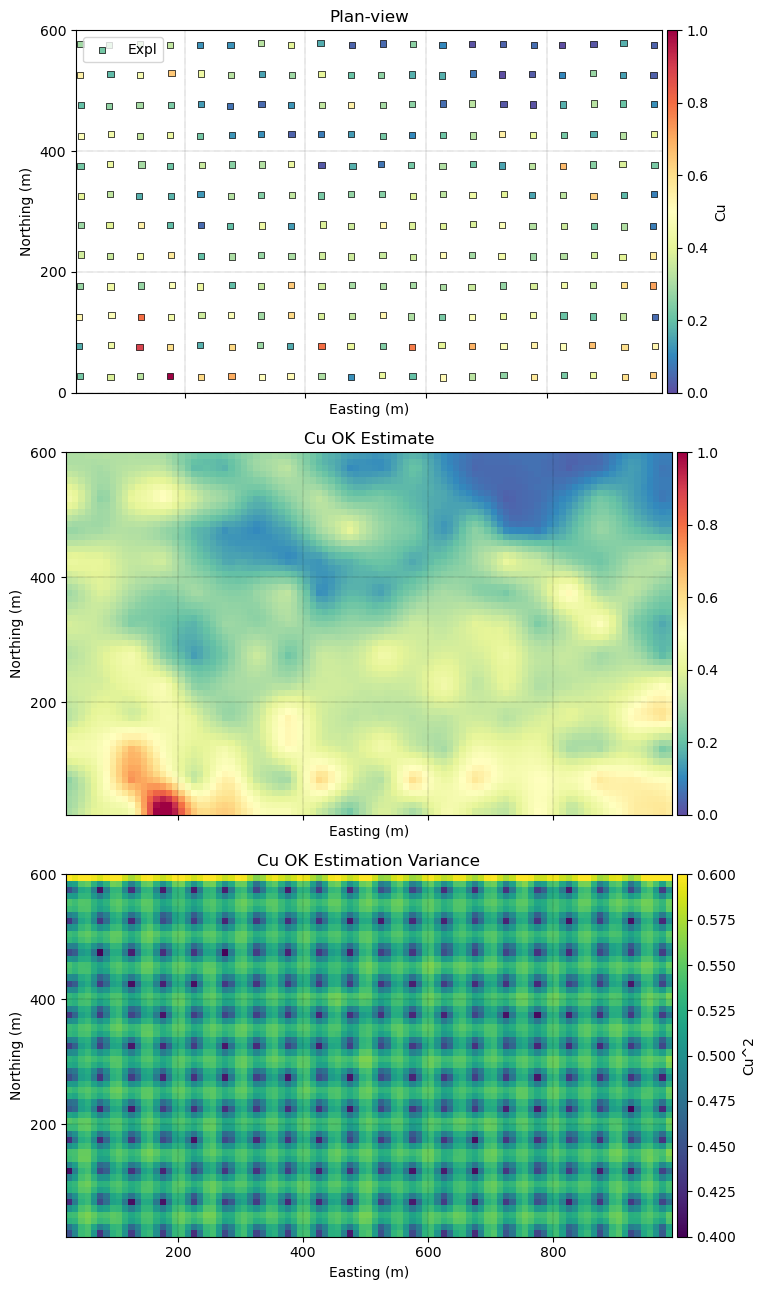

In [31]:
cu.clone("Cu OK Estimate")
fig, axes = plot_estimate(
    expl.col,
    bh.col,
    "Cu OK Estimate",
    "Cu OK Estimation Variance",
    include_bh=False,
)

## Ordinary kriging with all data with all data

Generate a column with exploration and blasthole data

In [32]:
comps["expl_bh Cu"] = comps["Expl Cu"]
mask = comps["BH Cu"].notna()
comps.loc[mask, "expl_bh Cu"] = comps.loc[mask, "BH Cu"]

Note the `'expl_bh Cu'` considers data from `'Expl Cu'` and `'BH Cu'`, and it is assumed as if both have the same support.

Setup `expl_bh Cu` to inherit (clone) the defined Cu plotting parameters, and setup dictionaries to standardize plotting of each dataset in section views.

In [33]:
expl_bh = cu.clone("expl_bh Cu")
expl_bh_pars = dict(label="Expl BH", marker="s", s=10, ec="k")

Define lags and variogram search

In [34]:
expl_bh_lags = rmsp.Lags(35, 25, 30)
expl_bh_search = rmsp.ExpVarioSearch(0.0, 0.0, expl_bh_lags, azmtol=90.0)

Calculate and model the experimental variogram

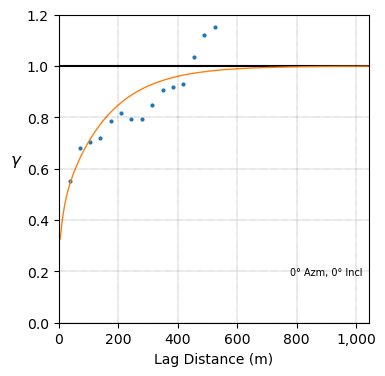

In [35]:
expl_bh_vario = rmsp.ExpVario().calculate(
    comps, expl_bh.col, expl_bh_search
)
expl_bh_vario_model = rmsp.VarioModel.fit_experimental(
    expl_bh_vario,
    nugget=0.25,
    shapes="exponential",
    range1=[[1, 450]] * 3,
    ranges12_bounds=1,
    ranges13_bounds=1,
)
_ = expl_bh_vario.gridplot(model=expl_bh_vario_model, figsize=(4, 4))

Initialize the OK estimator, using the variogram calculated with the exploration and blasthole data

In [36]:
search_expl_bh = rmsp.Search(
    ranges=(300, 300, 1), min_comps=2, max_comps=24
)

In [37]:
krige_expl_bh = rmsp.KrigeEstimator(
    search=search_expl_bh, vario=expl_bh_vario_model
)

Estimate across the grid:

In [38]:
(
    grid["Cu OK expl_bh Estimate"],
    grid["Cu OK expl_bh Estimation Variance"],
) = krige_expl_bh.estimate(
    grid,
    comps,
    expl_bh.col,
    output=["estimate", "estimate_var"],
    copy_meta=False,
)

Plot the OK estimates using all the data and compare to the OK estimates above. Observe the less smoother texture:

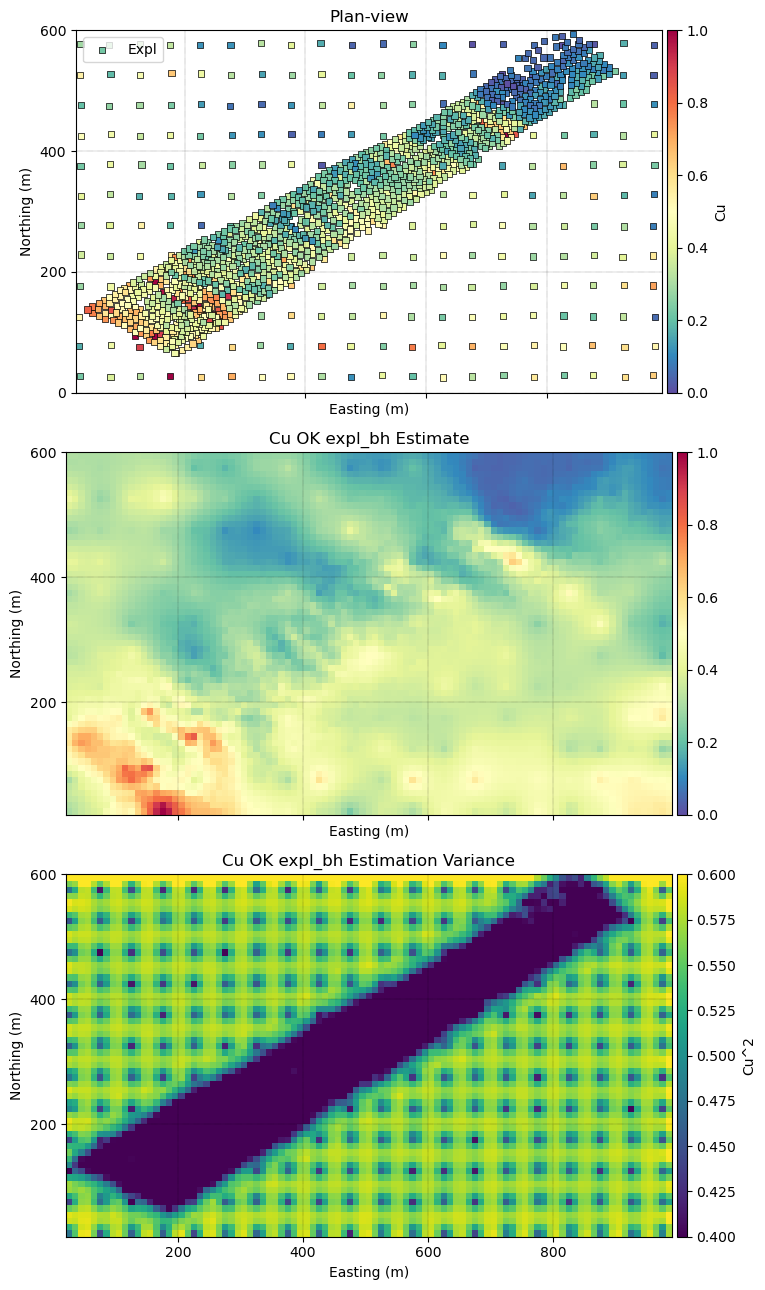

In [39]:
cu.clone("Cu OK expl_bh Estimate")
fig, axes = plot_estimate(
    expl_bh.col,
    bh.col,
    "Cu OK expl_bh Estimate",
    "Cu OK expl_bh Estimation Variance",
    include_bh=False,
)

## Cross-validation and visual comparison

Cross-validate using all estimators:

In [40]:
okdf = krige.loocv(comps, expl.col)
ok_expl_bh_df = krige_expl_bh.loocv(
    comps, expl_bh.col, keyout=comps[expl.col].notna().values
)
ockdf = cokrige.loocv(comps, variables)
intrinsicdf = intrinsic.loocv(comps, variables)

Plot all results to compare the methods, observing that:
- OK with all data improves $R^2$ relative to OK using only exploration data, but also leads to a global bias in the estimates ($m_x$) associated with treating the BH and exploration data the same
- OCK outperforms both OK approaches in terms of improving SOR, $R^2$ and $\rho_s$, while avoiding any significant global bias
- The intrinsic coregionalization model yields virtually identical results to the LMC, supporting its use given the far more simple parameterization

This result supports the use of OCK (and often the intinsic model) when modeling with data of differing quality.

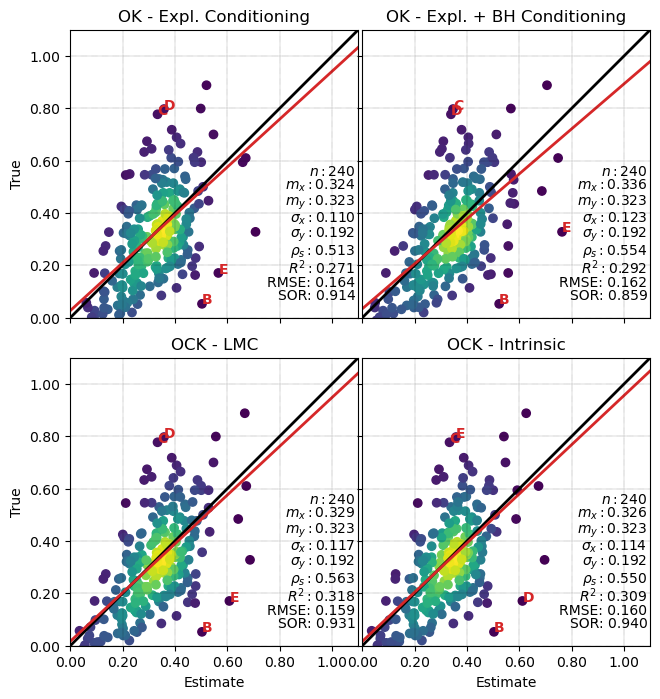

In [41]:
fig, axes = rmsp.ImageGrid(2, 2, figsize=(8, 8))
rmsp.CrossVal(okdf).scatplot(okdf, title="OK - Expl. Conditioning", ax=axes[0], lim=(0, 1.1))
rmsp.CrossVal(ok_expl_bh_df).scatplot(
    ok_expl_bh_df, title="OK - Expl. + BH Conditioning", ax=axes[1], lim=(0, 1.1))
rmsp.CrossVal(ockdf).scatplot(
    ockdf, title="OCK - LMC", ax=axes[2], lim=(0, 1.1))
rmsp.CrossVal(intrinsicdf).scatplot(
    intrinsicdf, title="OCK - Intrinsic", ax=axes[3], lim=(0, 1.1))

Plot all results to compare the methods visually. The top left result is the most visually distinctive since the BH data is not utilized, leading to a smoother result.

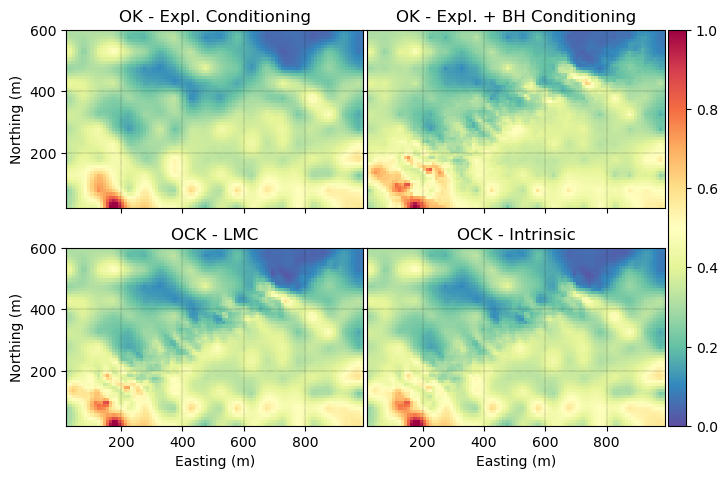

In [42]:
fig, axes = rmsp.ImageGrid(2, 2, figsize=(8, 18), cbar_mode='single')
grid.sectionplot("Cu OK Estimate", ax=axes[0], title="OK - Expl. Conditioning")
grid.sectionplot("Cu OK expl_bh Estimate", ax=axes[1], title="OK - Expl. + BH Conditioning")
grid.sectionplot("Cu OCK Estimate", ax=axes[2], title="OCK - LMC")
grid.sectionplot("Cu OCK intrinsic Estimate", ax=axes[3], title="OCK - Intrinsic")

---

# Closing Comments

This notebook provides the code for the lesson [Cokriging with Unequally Sampled Data](https://geostatisticslessons.com/lessons/cokrigingunequal). Note that the data used in the lesson has preprocessed the copper values by top cutting to a value of 1.0 and differences in the final figures can be recognized. An omnidirectional variogram/cross-variogram is used for simplicity of presentation; however, a directional variogram model would be fit and used in practice.

The notebook illustrates the use of cross-covariance for indirectly assessing the cross-covariance in the absence of colocated pairs. Locally accurate but globally biased blast holes are shown to be effectively incorporated into the estimation process. According to cross-validation, the cokriging results significantly improve local accuracy relative to ordinary kriging through integration of those blast holes, while avoiding the transmission of global bias.

Although not present in the lesson, this notebook also demonstrates that an intrinsic model of coregionalization is far more practical than an LMC in terms of fitting. Although greater flexibility of the LMC yields a slightly improved fit, it is shown to not have a material impact on estimation results in this example.

<footer>
<div style="text-align:center">    
    <p style="text-align:center; color:#00797C"> Partners: </p>
    <a href="https://resourcemodelingsolutions.com"><img class="rs" style="max-width:200px;"    src="https://geostatisticslessons.com/images/icons/resource_modeling_solutions_logo.png">
    </a>
    <a  href="https://geostatisticslessons.com/termsofuse"> <p style="text-align:center; color:#00797C">  Terms of Use </p></a>
    <a href="mailto:contact@resmodsol.com"> <p style="text-align:center; color:#00589d">Contact Resource Modeling Solutions about a commercial or academic license for RMSP</p> </a>
</div>
</footer>